# Initialization

In [1]:
# Importing required modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
%matplotlib notebook

In [2]:
# Reading the dataset
df = pd.read_csv('insurance.txt')

# Dropping 'children' column
df.drop(columns = 'children', inplace = True)

df.head()

,age,bmi,charges
0,19,27.900,16884.92400
1,18,33.770,1725.55230
2,28,33.000,4449.46200
3,33,22.705,21984.47061
4,32,28.880,3866.85520


## Function to normalize dataset
### normalize_dataset function normalizes the dataset by using the formula
## $X_{normalized} = \frac {X - min(X_i)} {max(X_i) - min(X_i)}$

In [3]:
def normalize_dataset():

    # normalize_coeff stores max and min of every column in dataset for denormalization
    normalize_coeff = {col: {'max': df[col].max(), 'min': df[col].min()} for col in df.columns}

    # normal_df is the normalized dataframe
    normal_df = (df - df.min()) / (df.max() - df.min())

    return pd.DataFrame(normal_df), normalize_coeff

In [4]:
normal_df, normalize_coeff = normalize_dataset()

normal_df.head()

,age,bmi,charges
0,0.021739,0.321227,0.251611
1,0.000000,0.479150,0.009636
2,0.217391,0.458434,0.053115
3,0.326087,0.181464,0.333010
4,0.304348,0.347592,0.043816


## Function to shuffle the dataset and return $X_{train}, Y_{train}, X_{val}, Y_{val}, X_{test}, Y_{test}$ matrices 

In [5]:
from math import ceil
def shuffle(dataframe, train_ratio, val_ratio, target):
    
    # Getting list of columns for X matrix
    columns = list(dataframe.columns)
    columns.remove(target)
    
    # Getting the max indices for training and validation set
    train_idx = ceil(len(dataframe) * train_ratio)
    val_idx = ceil(len(dataframe) * (train_ratio + val_ratio))
    
    # Shuffling the dataset
    sf = dataframe.sample(frac = 1)
    
    # Dividing X and Y matrices
    X = sf[columns]
    Y = sf[target]
    
    # Generating train, validation and test sets
    X_train = X.iloc[:train_idx].to_numpy().reshape((-1, len(columns)))
    X_val = X.iloc[train_idx : val_idx].to_numpy().reshape((-1, len(columns)))
    X_test = X.iloc[val_idx:].to_numpy().reshape((-1, len(columns)))
    
    Y_train = Y.iloc[:train_idx].to_numpy().reshape((-1, 1))
    Y_val = Y.iloc[train_idx : val_idx].to_numpy().reshape((-1, 1))
    Y_test = Y.iloc[val_idx:].to_numpy().reshape((-1, 1))
    
    return X_train, Y_train, X_val, Y_val, X_test, Y_test

## Function to initialize weights

In [6]:
def initialize_weights(X):
    num_features = X.shape[1]
    W = np.zeros((num_features, 1))
    return W

## Function to predict the results

In [7]:
def predict(W, X):
    predictions = X @ W         # '@' performs matrix multiplication
    return predictions

## Function to normalize a value

In [8]:
def normalize(value, name):
    nc = normalize_coeff[name]
    out = (value - nc['min']) / (nc['max'] - nc['min'])
    return out

## Function to denormalize a value

In [9]:
def denormalize(value, name):
    nc = normalize_coeff[name]
    out = value * (nc['max'] - nc['min']) + nc['min']
    return out

## Functions to calculate Error and Accuracy
### Metric used for error -> MSE
## $ MSE = \frac {\sum_{i=1}^{m}{(y_i - \hat y_i)^2}} {2m} $

In [10]:
def calculate_error(y, y_hat):
    y = y.flatten()
    y_hat = y_hat.flatten()
    sq_err = np.sum((y - y_hat) ** 2)
    mse = sq_err / (2 * len(y))
    return mse

### Metric used for accuracy -> $ R^2 $
## $ R^2 = 1- \frac {2 \times MSE} {Var(Y)} $

In [11]:
def calculate_accuracy(y, y_hat):
    y = y.flatten()
    y_hat = y_hat.flatten()
    mse = calculate_error(y, y_hat)
    var_y = np.var(y)
    rMSE = 2 * mse / var_y
    R2 = 1 - rMSE
    return R2

## Cost Function
### Lasso Cost = $ MSE + \frac {\lambda_1} {2m} \sum_{i=1}^M |W_i| $
### Ridge Cost = $ MSE + \frac {\lambda_2} {2m} \sum_{i=1}^M W_i^2 $

In [12]:
def calculate_cost(y, y_hat, W, lambda1 = 0, lambda2 = 0):
    mse = calculate_error(y, y_hat)
    reg1 = lambda1 / (2 * len(y)) * np.sum(np.abs(W))
    reg2 = lambda2 / (2 * len(y)) * (W.T @ W).flatten()[0]
    cost = mse + reg1 + reg2
    return cost

# Building Gradient Descent model
## Function for finding W using Gradient Descent

In [13]:
def gradient_descent(X, y, W, eta = 0.1, lambda1 = 0, lambda2 = 0, num_iterations = 2000):
    print_space = num_iterations // 5 if num_iterations > 5 else 1
    m = len(X)
    J = {}
    accuracy = {}
    for i in range(1, num_iterations + 1):
        dReg1 = lambda1 / (2 * m) * np.sign(W)
        dReg2 = (lambda2 / m) * W
        dW_old = (1 / m) * (X.T @ (X @ W - y))
        dW = dW_old + dReg1 + dReg2
        W = W - (eta * dW)
        prediction = predict(W, X)
        cost = calculate_cost(y, prediction, W, lambda1, lambda2)
        J[i] = cost
        acc = calculate_accuracy(y, prediction)
        accuracy[i] = acc
        if i == 1 or i % print_space == 0:
            print(f'Cost after {i} iterations is {cost}, accuracy = {acc}')
    return W, J, accuracy

## Applying Gradient Descent

In [14]:
# Initializing important variables
W_gd = {}
train_cost_gd = {}
train_accuracy_gd = {}
val_cost_gd = {}
val_accuracy_gd = {}

### Running without regularization for various learning rates

In [15]:
temp_W_gd = {}
temp_train_cost_gd = {}
temp_train_accuracy_gd = {}
temp_val_cost_gd = {}
temp_val_accuracy_gd = {}

etas = [0.001, 0.01, 0.1]
max_degree = 10
X_train, Y_train, X_val, Y_val, _, _ = shuffle(normal_df, train_ratio = 0.7, val_ratio = 0.2, target = 'charges')

for eta in etas:
    temp_W_gd[eta] = {}
    temp_train_cost_gd[eta] = {}
    temp_train_accuracy_gd[eta] = {}
    temp_val_cost_gd[eta] = {}
    temp_val_accuracy_gd[eta] = {}

    for i in range(1, max_degree + 1):
        print(f'Training {i}-degree model with learning rate = {eta}')
        
        poly = PolynomialFeatures(i)
        X_train_poly = poly.fit_transform(X_train)
        X_val_poly = poly.fit_transform(X_val)
        
        W = initialize_weights(X_train_poly)
        temp_W_gd[eta][i], temp_train_cost_gd[eta][i], temp_train_accuracy_gd[eta][i] = \
                                                                                gradient_descent(X_train_poly, Y_train, W, eta)
        predictions = predict(temp_W_gd[eta][i], X_val_poly)
        temp_val_cost_gd[eta][i] = calculate_cost(Y_val, predictions, temp_W_gd[eta][i])
        temp_val_accuracy_gd[eta][i] = calculate_accuracy(Y_val, predictions)
        print()
        print(f'Validation Cost = {temp_val_cost_gd[eta][i]}, Validation Accuracy = {temp_val_accuracy_gd[eta][i]}')
        print()

Training 1-degree model with learning rate = 0.001
Cost after 1 iterations is 0.038097578086461595, accuracy = -1.0395658034816782
Cost after 400 iterations is 0.0240315550210279, accuracy = -0.28653684268697877
Cost after 800 iterations is 0.01937693936378964, accuracy = -0.03735053217378792
Cost after 1200 iterations is 0.017822893587276765, accuracy = 0.04584579635994479
Cost after 1600 iterations is 0.017285168510324373, accuracy = 0.07463307717180256
Cost after 2000 iterations is 0.01708166069474722, accuracy = 0.08552793196940756

Validation Cost = 0.017509394399290026, Validation Accuracy = 0.05941248669670007

Training 2-degree model with learning rate = 0.001
Cost after 1 iterations is 0.038087158859057266, accuracy = -1.0390080068715015
Cost after 400 iterations is 0.022584577921559965, accuracy = -0.20907246939274415
Cost after 800 iterations is 0.018238273748094832, accuracy = 0.023608289043165698
Cost after 1200 iterations is 0.017009798217837317, accuracy = 0.089375112231

Cost after 400 iterations is 0.016336937483297474, accuracy = 0.12539692289803883
Cost after 800 iterations is 0.016324116992486433, accuracy = 0.1260832718985634
Cost after 1200 iterations is 0.016314818005416606, accuracy = 0.1265810960907363
Cost after 1600 iterations is 0.01630702744214391, accuracy = 0.12699816634136463
Cost after 2000 iterations is 0.01630021474361454, accuracy = 0.12736288629596126

Validation Cost = 0.017223921050227416, Validation Accuracy = 0.07474783533217622

Training 5-degree model with learning rate = 0.01
Cost after 1 iterations is 0.03734368081137379, accuracy = -0.9992056761760131
Cost after 400 iterations is 0.016356971538130562, accuracy = 0.12432439348291668
Cost after 800 iterations is 0.016340712185583528, accuracy = 0.12519484302609818
Cost after 1200 iterations is 0.016327046316093323, accuracy = 0.12592644963961597
Cost after 1600 iterations is 0.016315312822430036, accuracy = 0.12655460590657597
Cost after 2000 iterations is 0.0163051151090287

Cost after 1200 iterations is 0.016188496633169257, accuracy = 0.13334375041222268
Cost after 1600 iterations is 0.016174022326706616, accuracy = 0.1341186369528662
Cost after 2000 iterations is 0.01616412268905023, accuracy = 0.1346486171627631

Validation Cost = 0.017460474949278586, Validation Accuracy = 0.06204039162528463

Training 8-degree model with learning rate = 0.1
Cost after 1 iterations is 0.03032905564017821, accuracy = -0.6236755154150486
Cost after 400 iterations is 0.016245162605359537, accuracy = 0.13031011980090013
Cost after 800 iterations is 0.01620155173879456, accuracy = 0.13264484123396003
Cost after 1200 iterations is 0.016177671247298117, accuracy = 0.13392329084343224
Cost after 1600 iterations is 0.016162605003509172, accuracy = 0.13472986693467648
Cost after 2000 iterations is 0.01615254086662273, accuracy = 0.13526865366249852

Validation Cost = 0.01749742829619687, Validation Accuracy = 0.06005529403176002

Training 9-degree model with learning rate = 0.1

### Visualizing the effect of learning rates

<IPython.core.display.Javascript object>


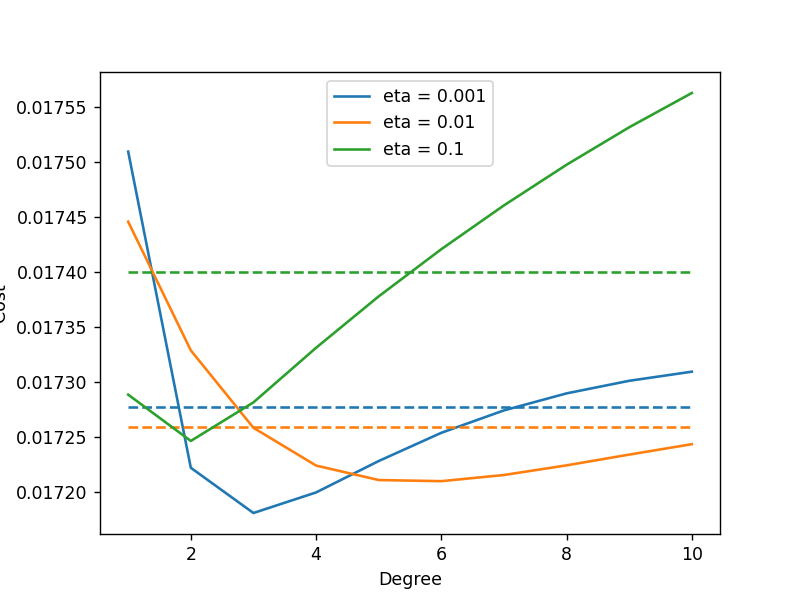

In [16]:
avg_cost = {}
plt.figure()
for eta in etas:
    color = next(plt.gca()._get_lines.prop_cycler)['color']
    plt.plot(list(temp_val_cost_gd[eta].keys()), list(temp_val_cost_gd[eta].values()), color = color, label = f'eta = {eta}')
    avg_cost[eta] = np.mean(list(temp_val_cost_gd[eta].values()))
    plt.plot(np.arange(1, max_degree + 1), [avg_cost[eta]] * max_degree, '--', color = color)
plt.xlabel('Degree')
plt.ylabel('Cost')
plt.legend();

### Finding best learning rate

In [17]:
best_eta_gd = min(avg_cost, key = avg_cost.get)
print(f'Best learning rate with lowest average validation cost is {best_eta_gd}')

W_gd['nr'] = temp_W_gd[best_eta_gd]
train_cost_gd['nr'] = temp_train_cost_gd[best_eta_gd]
train_accuracy_gd['nr'] = temp_train_accuracy_gd[best_eta_gd]
val_cost_gd['nr'] = temp_val_cost_gd[best_eta_gd]
val_accuracy_gd['nr'] = temp_val_accuracy_gd[best_eta_gd]

Best learning rate with lowest average validation cost is 0.01


In [36]:
val_cost_gd['nr']

{1: 0.01744563547927405,
 2: 0.017328661537058965,
 3: 0.017258259551000618,
 4: 0.017223921050227416,
 5: 0.017210748953555954,
 6: 0.01720971499614414,
 7: 0.01721533197160271,
 8: 0.01722410894280768,
 9: 0.017233873631722844,
 10: 0.017243357486912858}

### Generating Surface Plots for different degrees

<IPython.core.display.Javascript object>


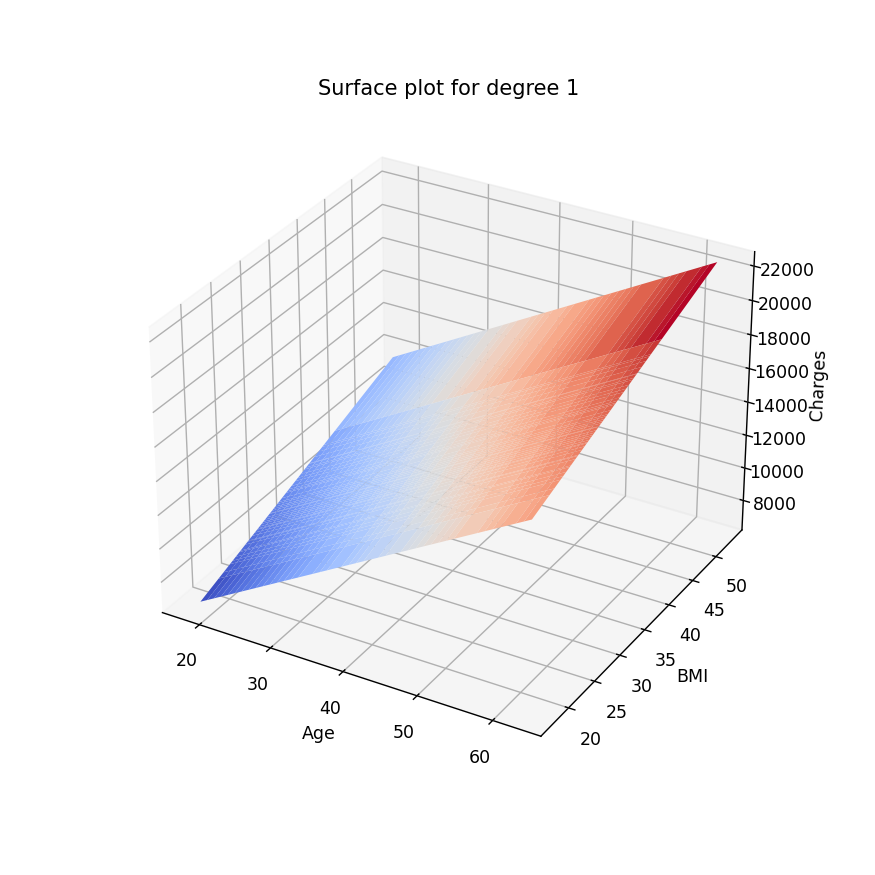

<IPython.core.display.Javascript object>


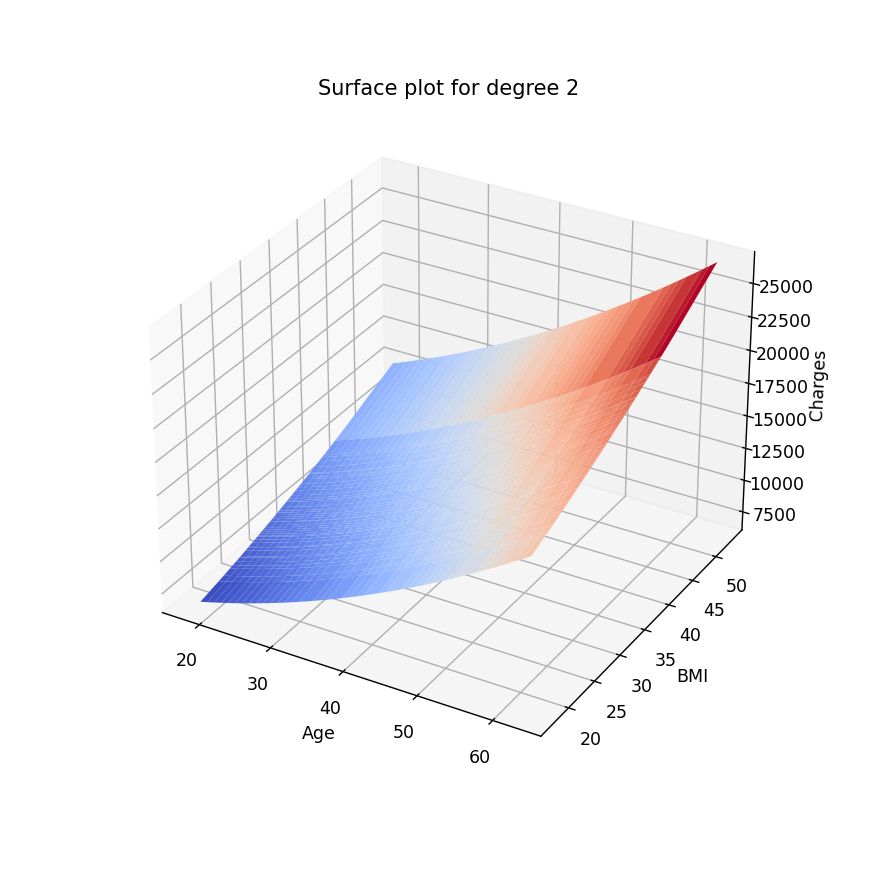

<IPython.core.display.Javascript object>


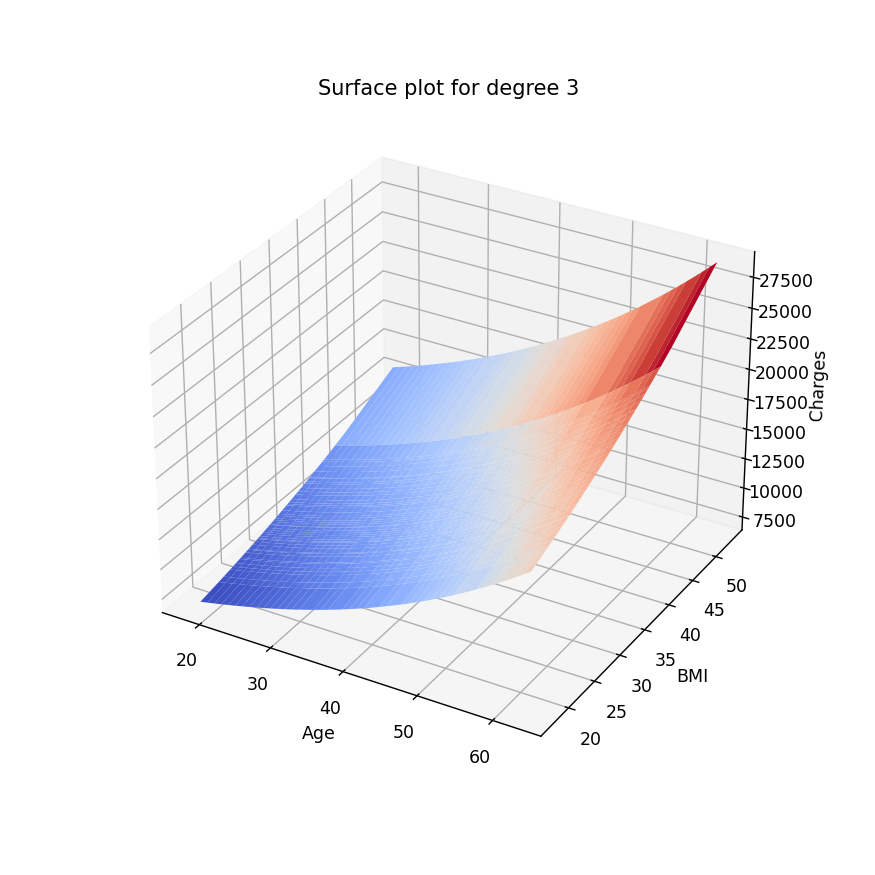

<IPython.core.display.Javascript object>


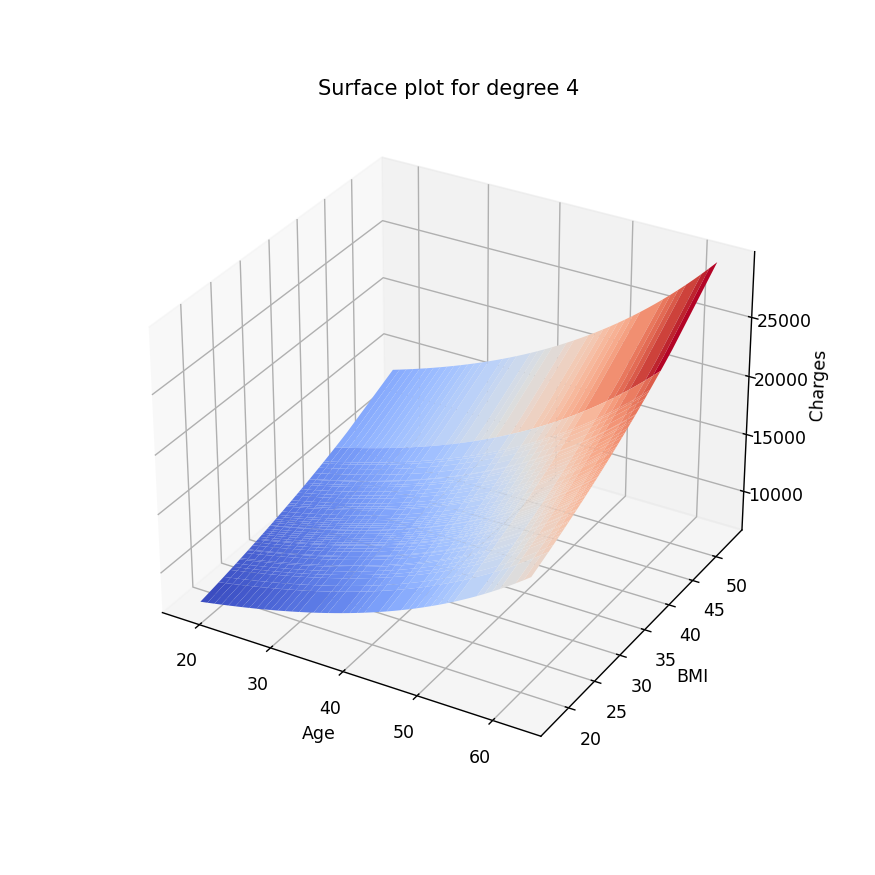

<IPython.core.display.Javascript object>


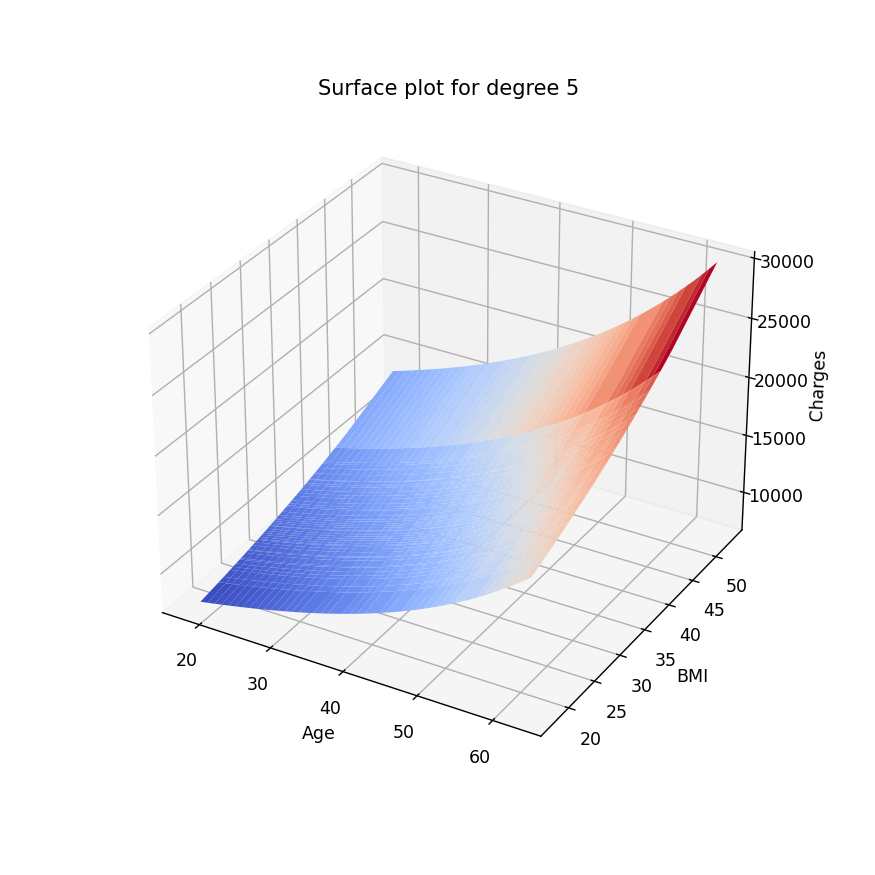

<IPython.core.display.Javascript object>


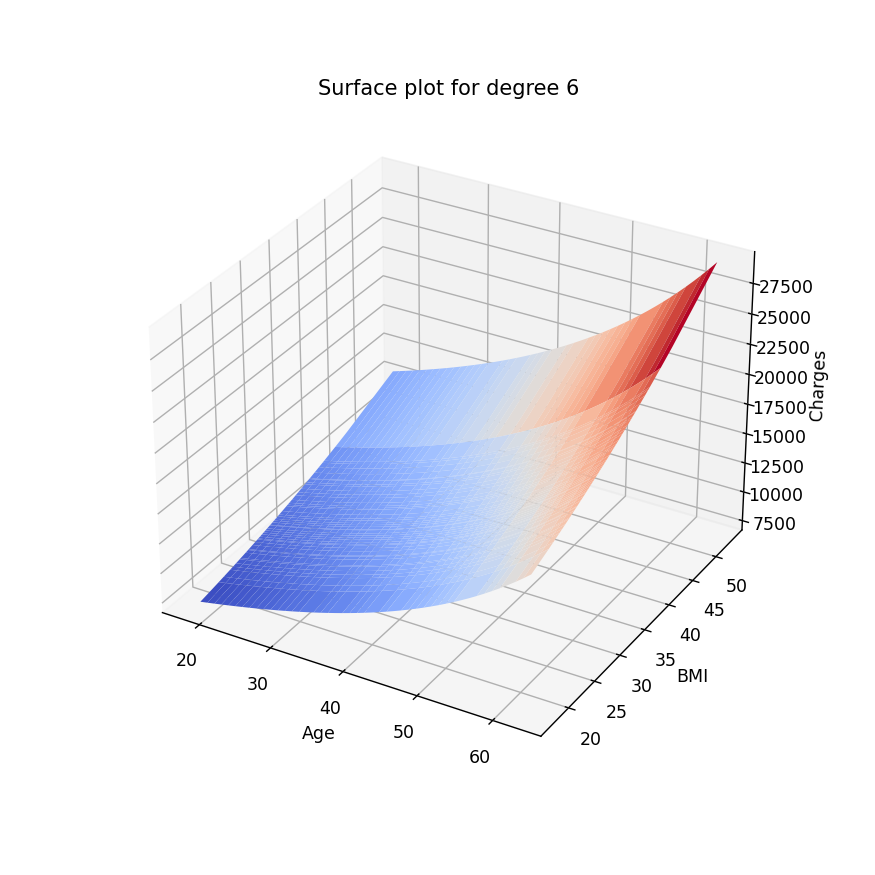

<IPython.core.display.Javascript object>


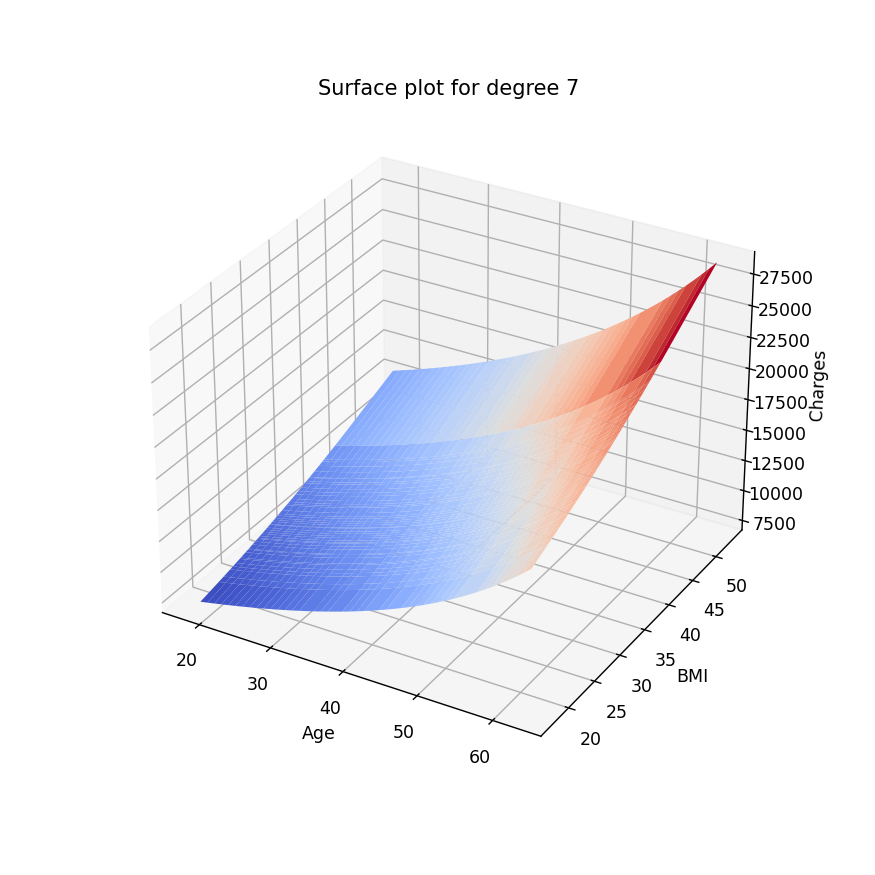

<IPython.core.display.Javascript object>


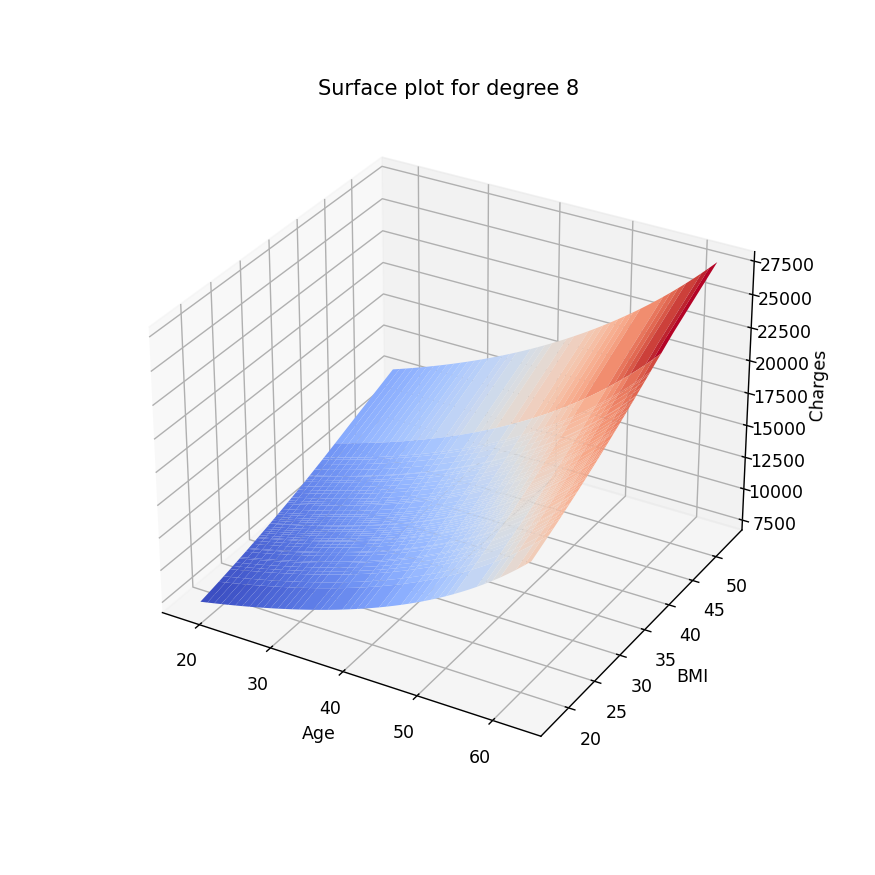

<IPython.core.display.Javascript object>


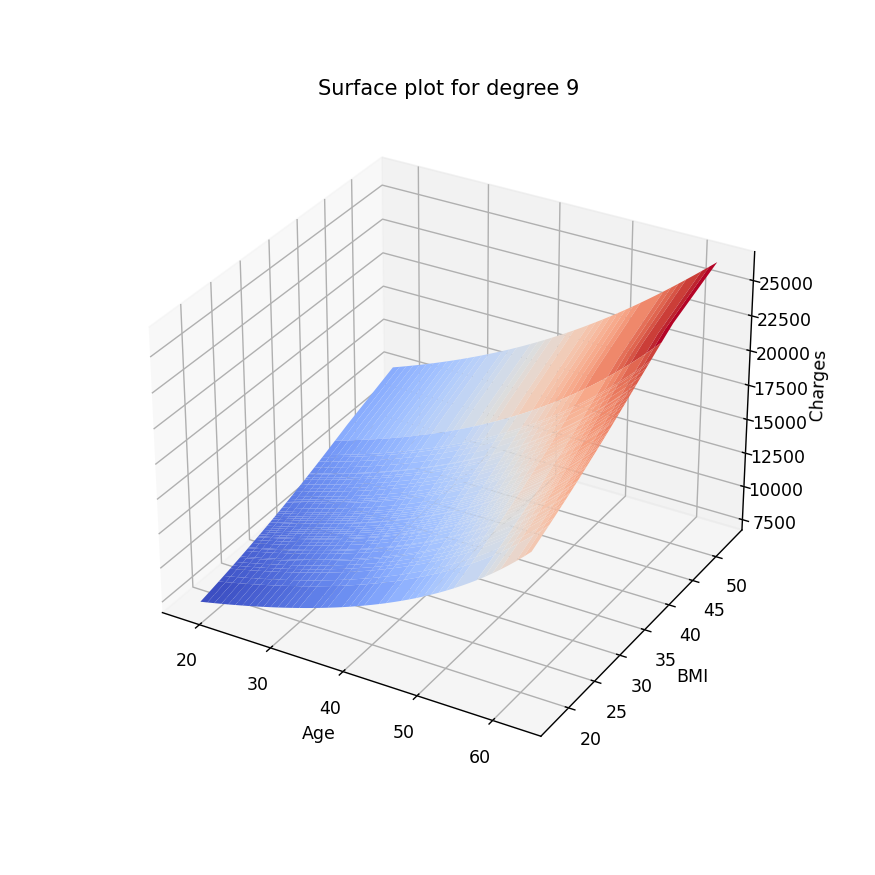

<IPython.core.display.Javascript object>


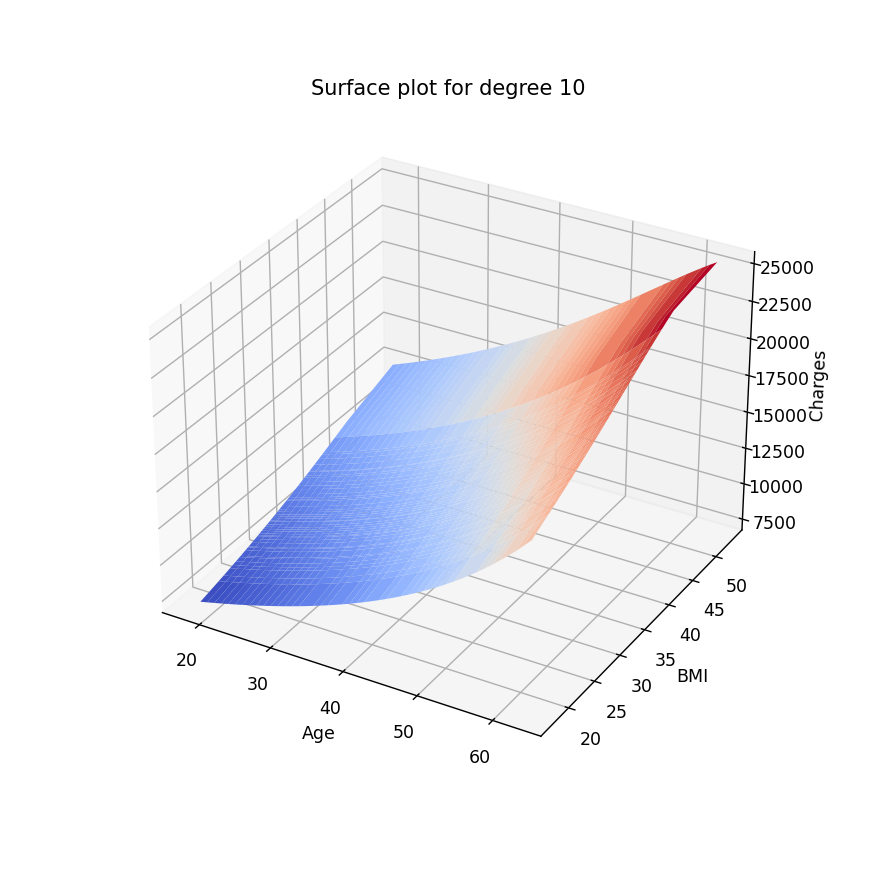

In [18]:
# Surface plot code
_, _, _, _, X_test, _ = shuffle(df, train_ratio = 0.7, val_ratio = 0.2, target = 'charges')

X_axis = X_test[:, 0]
Y_axis = X_test[:, 1]
X_axis = np.sort(X_axis)
Y_axis = np.sort(Y_axis)
X_axis, Y_axis = np.meshgrid(X_axis, Y_axis)

for i in range(1, max_degree + 1):
    poly = PolynomialFeatures(i)
    Z = np.zeros(X_axis.shape)
    
    for j in range(X_axis.shape[0]):
        for k in range(X_axis.shape[1]):
            X_normalized = normalize(X_axis[j, k], name = 'age')
            Y_normalized = normalize(Y_axis[j, k], name = 'bmi')
            arr = np.array([X_normalized, Y_normalized]).reshape(-1, 2)
            poly_features = poly.fit_transform(arr)
            pred = predict(W_gd['nr'][i], poly_features).flatten()[0]
            pred_denormalized = denormalize(pred, name = 'charges')
            Z[j, k] = pred_denormalized
    
#     a = np.vstack((X_axis, Y_axis, Z)).T
#     a = a[np.lexsort((a[:,0], a[:,1]))]
#     n = a.T.shape[0]
#     xs = a.T[:(n//3), :]
#     ys = a.T[(n//3):2*(n//3), :]
#     zs = a.T[2*(n//3):n, :]
    
    plt.figure(figsize = (7, 7))
    ax = plt.axes(projection = '3d')
    ax.plot_surface(X_axis, Y_axis, Z, cmap = 'coolwarm')
#     ax.plot_surface(xs, ys, zs, cmap = 'coolwarm')
    ax.set_xlabel('Age')
    ax.set_ylabel('BMI')
    ax.set_zlabel('Charges')
    ax.set_title(f'Surface plot for degree {i}')

### Running with Lasso Regularization for various $ \lambda $

In [19]:
temp_W_gd = {}
temp_train_cost_gd = {}
temp_train_accuracy_gd = {}
temp_val_cost_gd = {}
temp_val_accuracy_gd = {}

max_degree = 10
num_lambdas = 10
X_train, Y_train, X_val, Y_val, _, _ = shuffle(normal_df, train_ratio = 0.7, val_ratio = 0.2, target = 'charges')

for i in range(1, max_degree + 1):
    temp_W_gd[i] = {}
    temp_train_cost_gd[i] = {}
    temp_train_accuracy_gd[i] = {}
    temp_val_cost_gd[i] = {}
    temp_val_accuracy_gd[i] = {}
    
    poly = PolynomialFeatures(i)
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.fit_transform(X_val)
    
    lambdas = np.random.uniform(0, 1, size = num_lambdas).tolist()
    for lambda1 in lambdas:
        print(f'Training {i}-degree model with lambda = {lambda1}')
        
        W = initialize_weights(X_train_poly)
        temp_W_gd[i][lambda1], temp_train_cost_gd[i][lambda1], temp_train_accuracy_gd[i][lambda1] = \
                                                gradient_descent(X_train_poly, Y_train, W, eta = best_eta_gd, lambda1 = lambda1)
        
        predictions = predict(temp_W_gd[i][lambda1], X_val_poly)
        temp_val_cost_gd[i][lambda1] = calculate_cost(Y_val, predictions, temp_W_gd[i][lambda1], lambda1 = lambda1)
        temp_val_accuracy_gd[i][lambda1] = calculate_accuracy(Y_val, predictions)
        print()
        print(f'Validation Cost = {temp_val_cost_gd[i][lambda1]}, Validation Accuracy = {temp_val_accuracy_gd[i][lambda1]}')
        print()

Training 1-degree model with lambda = 0.19382542878308817
Cost after 1 iterations is 0.0376923822561637, accuracy = -0.9661098165280846
Cost after 400 iterations is 0.017575798526477372, accuracy = 0.08478565293741247
Cost after 800 iterations is 0.01739390615404827, accuracy = 0.09436697731485277
Cost after 1200 iterations is 0.017282776812818066, accuracy = 0.10023534301474102
Cost after 1600 iterations is 0.017211377609009537, accuracy = 0.10401878083141258
Cost after 2000 iterations is 0.01716306716322046, accuracy = 0.10658816493187018

Validation Cost = 0.016997587863575303, Validation Accuracy = 0.09397411137460787

Training 1-degree model with lambda = 0.15334788064000493
Cost after 1 iterations is 0.03769229881731347, accuracy = -0.9661098165280846
Cost after 400 iterations is 0.017569082548771743, accuracy = 0.08480548516004172
Cost after 800 iterations is 0.01738666633566531, accuracy = 0.09439476733741703
Cost after 1200 iterations is 0.017275171405773358, accuracy = 0.1002

Cost after 800 iterations is 0.01721770456077887, accuracy = 0.10802777120012697
Cost after 1200 iterations is 0.017181187292210267, accuracy = 0.11015473311059798
Cost after 1600 iterations is 0.017159245918889388, accuracy = 0.11146519312249281
Cost after 2000 iterations is 0.017144740879362567, accuracy = 0.11234957677832302

Validation Cost = 0.017247673409894585, Validation Accuracy = 0.09784066984463347

Training 2-degree model with lambda = 0.27483379656729523
Cost after 1 iterations is 0.03759742426772483, accuracy = -0.9611353177724464
Cost after 400 iterations is 0.017227632794200323, accuracy = 0.10419098263290505
Cost after 800 iterations is 0.01715276135763176, accuracy = 0.10825525267464742
Cost after 1200 iterations is 0.01711392710808592, accuracy = 0.11039248015566827
Cost after 1600 iterations is 0.017090506101547755, accuracy = 0.11169782093917091
Cost after 2000 iterations is 0.017075025684949563, accuracy = 0.11256995565062733

Validation Cost = 0.01701667093711319

Cost after 1200 iterations is 0.01711883008282894, accuracy = 0.11092812168736621
Cost after 1600 iterations is 0.01710462836727801, accuracy = 0.11174422454463262
Cost after 2000 iterations is 0.017094825835484072, accuracy = 0.11231033412064528

Validation Cost = 0.017079553644773215, Validation Accuracy = 0.09735595509630168

Training 3-degree model with lambda = 0.5175817819008033
Cost after 1 iterations is 0.03754232467649694, accuracy = -0.9582041020467196
Cost after 400 iterations is 0.01722453392927597, accuracy = 0.10759677332797035
Cost after 800 iterations is 0.017191703894477085, accuracy = 0.10955255553551912
Cost after 1200 iterations is 0.017171390214162325, accuracy = 0.11077657584514489
Cost after 1600 iterations is 0.01715776858408167, accuracy = 0.11160421725616487
Cost after 2000 iterations is 0.017148190478296573, accuracy = 0.11218799120538026

Validation Cost = 0.017256674040103493, Validation Accuracy = 0.09742342611624466

Training 3-degree model with lambda = 

Cost after 1600 iterations is 0.017227594303907395, accuracy = 0.11100146849948389
Cost after 2000 iterations is 0.017216372179051538, accuracy = 0.11162296912231107

Validation Cost = 0.017458898560149778, Validation Accuracy = 0.09733136974918055

Training 5-degree model with lambda = 0.39259206324524254
Cost after 1 iterations is 0.03747968898080559, accuracy = -0.9549369512361006
Cost after 400 iterations is 0.01721961289266565, accuracy = 0.10706531538250064
Cost after 800 iterations is 0.017185208940481676, accuracy = 0.10891585344615717
Cost after 1200 iterations is 0.017163160312117186, accuracy = 0.11011268622674597
Cost after 1600 iterations is 0.017146809399135463, accuracy = 0.11098835979566213
Cost after 2000 iterations is 0.017133893924966757, accuracy = 0.11166185559906283

Validation Cost = 0.01718143364355372, Validation Accuracy = 0.09688596815888184

Training 5-degree model with lambda = 0.3958249567879343
Cost after 1 iterations is 0.03747970462282427, accuracy = -0

Cost after 1600 iterations is 0.017249945138447697, accuracy = 0.11075016811186611
Cost after 2000 iterations is 0.017235762598657434, accuracy = 0.11148915007575866

Validation Cost = 0.01751377423477203, Validation Accuracy = 0.09754341887536444

Training 6-degree model with lambda = 0.4686711580463411
Cost after 1 iterations is 0.03746083296292047, accuracy = -0.9539226534654612
Cost after 400 iterations is 0.017253268166751986, accuracy = 0.10650740062891251
Cost after 800 iterations is 0.017211025832499657, accuracy = 0.10866293231126456
Cost after 1200 iterations is 0.017185419641671182, accuracy = 0.10999036706737053
Cost after 1600 iterations is 0.017167061925967557, accuracy = 0.11095256831331257
Cost after 2000 iterations is 0.017153409853749784, accuracy = 0.11166553790133593

Validation Cost = 0.017248393154049534, Validation Accuracy = 0.09696759925690057

Training 6-degree model with lambda = 0.05184010086190893
Cost after 1 iterations is 0.03745861977016145, accuracy = -

Cost after 2000 iterations is 0.017196868312384556, accuracy = 0.11162189322869687

Validation Cost = 0.017393086010974487, Validation Accuracy = 0.09719979603272211

Training 7-degree model with lambda = 0.19945569406662844
Cost after 1 iterations is 0.03744424345591818, accuracy = -0.9531275202860356
Cost after 400 iterations is 0.017189639920528747, accuracy = 0.10621166237402957
Cost after 800 iterations is 0.017141030722765047, accuracy = 0.10872446084837928
Cost after 1200 iterations is 0.01711413306711469, accuracy = 0.11013750538318146
Cost after 1600 iterations is 0.01709564120977803, accuracy = 0.11112518337386468
Cost after 2000 iterations is 0.017082274641569334, accuracy = 0.11184755319433082

Validation Cost = 0.017029474710109647, Validation Accuracy = 0.09602310267759973

Training 7-degree model with lambda = 0.09298944329520542
Cost after 1 iterations is 0.03744363371040144, accuracy = -0.9531275202860356
Cost after 400 iterations is 0.017160320417136363, accuracy = 0.

Cost after 400 iterations is 0.01728378973940806, accuracy = 0.10598276667586137
Cost after 800 iterations is 0.017230165914143086, accuracy = 0.10857784783882485
Cost after 1200 iterations is 0.017202853080759823, accuracy = 0.11000064031387147
Cost after 1600 iterations is 0.01718382250832619, accuracy = 0.1109977478991876
Cost after 2000 iterations is 0.017169886777153625, accuracy = 0.11172216935161539

Validation Cost = 0.01731282644115405, Validation Accuracy = 0.09680491318579776

Training 9-degree model with lambda = 0.9272900387918143
Cost after 1 iterations is 0.037426408607849404, accuracy = -0.9519452112534081
Cost after 400 iterations is 0.01738358257826278, accuracy = 0.10581705374830697
Cost after 800 iterations is 0.017327994787720336, accuracy = 0.10827796598326533
Cost after 1200 iterations is 0.017299455741171435, accuracy = 0.1096819215430308
Cost after 1600 iterations is 0.01727978812403731, accuracy = 0.11070181753579533
Cost after 2000 iterations is 0.01726539959

Cost after 400 iterations is 0.01723195726986978, accuracy = 0.10597039518613605
Cost after 800 iterations is 0.017175583531628826, accuracy = 0.10884060437318821
Cost after 1200 iterations is 0.017148178738007787, accuracy = 0.11032088246504712
Cost after 1600 iterations is 0.017129884205363644, accuracy = 0.11132267702523724
Cost after 2000 iterations is 0.017116786657501316, accuracy = 0.1120378892749132

Validation Cost = 0.017167594188665952, Validation Accuracy = 0.09577080141913319

Training 10-degree model with lambda = 0.746169783581268
Cost after 1 iterations is 0.037416707515762114, accuracy = -0.9514879206579527
Cost after 400 iterations is 0.017338152989940462, accuracy = 0.10588307301465683
Cost after 800 iterations is 0.017282397571495915, accuracy = 0.10846839763404514
Cost after 1200 iterations is 0.017254599698778454, accuracy = 0.10988214430630328
Cost after 1600 iterations is 0.01723531358110499, accuracy = 0.11087492306754887
Cost after 2000 iterations is 0.0172212

### Finding best $ \lambda $ for different degrees

In [20]:
best_lambda1_gd = {i: min(temp_val_cost_gd[i], key = temp_val_cost_gd[i].get) for i in range(1, max_degree + 1)}
best_lambda1_gd

{1: 0.02196291437396658,
 2: 0.01359552078023818,
 3: 0.11760510423031212,
 4: 0.08063110317132927,
 5: 0.0072944670250040256,
 6: 0.05184010086190893,
 7: 0.06359466050263585,
 8: 0.1016148188801912,
 9: 0.0018894256868611237,
 10: 0.05088236611818309}

In [21]:
W_gd['r1'] = {i: {'W':temp_W_gd[i][best_lambda1_gd[i]], 'lambda': best_lambda1_gd[i]} for i in range(1, max_degree + 1)}
train_cost_gd['r1'] = {i: {'cost':temp_train_cost_gd[i][best_lambda1_gd[i]], 'lambda': best_lambda1_gd[i]} for i in range(1, max_degree + 1)}
train_accuracy_gd['r1'] = {i: {'cost':temp_train_accuracy_gd[i][best_lambda1_gd[i]], 'lambda': best_lambda1_gd[i]} for i in range(1, max_degree + 1)}
val_cost_gd['r1'] = {i: {'cost':temp_val_cost_gd[i][best_lambda1_gd[i]], 'lambda': best_lambda1_gd[i]} for i in range(1, max_degree + 1)}
val_accuracy_gd['r1'] = {i: {'cost':temp_val_accuracy_gd[i][best_lambda1_gd[i]], 'lambda': best_lambda1_gd[i]} for i in range(1, max_degree + 1)}

In [37]:
val_cost_gd['r1']

{1: {'cost': 0.01688467002128184, 'lambda': 0.02196291437396658},
 2: {'cost': 0.016808383283699768, 'lambda': 0.01359552078023818},
 3: {'cost': 0.016915326414195832, 'lambda': 0.11760510423031212},
 4: {'cost': 0.016900574301755626, 'lambda': 0.08063110317132927},
 5: {'cost': 0.01684366132509726, 'lambda': 0.0072944670250040256},
 6: {'cost': 0.016890950463450953, 'lambda': 0.05184010086190893},
 7: {'cost': 0.01690865656465338, 'lambda': 0.06359466050263585},
 8: {'cost': 0.016951549725855667, 'lambda': 0.1016148188801912},
 9: {'cost': 0.01686575838329003, 'lambda': 0.0018894256868611237},
 10: {'cost': 0.016921719613388637, 'lambda': 0.05088236611818309}}

### Running with Ridge Regularization for various $ \lambda $

In [22]:
temp_W_gd = {}
temp_train_cost_gd = {}
temp_train_accuracy_gd = {}
temp_val_cost_gd = {}
temp_val_accuracy_gd = {}

max_degree = 10
num_lambdas = 10
X_train, Y_train, X_val, Y_val, _, _ = shuffle(normal_df, train_ratio = 0.7, val_ratio = 0.2, target = 'charges')

for i in range(1, max_degree + 1):
    temp_W_gd[i] = {}
    temp_train_cost_gd[i] = {}
    temp_train_accuracy_gd[i] = {}
    temp_val_cost_gd[i] = {}
    temp_val_accuracy_gd[i] = {}
    
    poly = PolynomialFeatures(i)
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.fit_transform(X_val)
    
    lambdas = np.random.uniform(0, 1, size = num_lambdas).tolist()
    for lambda2 in lambdas:
        print(f'Training {i}-degree model with lambda = {lambda2}')
        
        W = initialize_weights(X_train_poly)
        temp_W_gd[i][lambda2], temp_train_cost_gd[i][lambda2], temp_train_accuracy_gd[i][lambda2] = \
                                                gradient_descent(X_train_poly, Y_train, W, eta = best_eta_gd, lambda2 = lambda2)
        
        predictions = predict(temp_W_gd[i][lambda2], X_val_poly)
        temp_val_cost_gd[i][lambda2] = calculate_cost(Y_val, predictions, temp_W_gd[i][lambda2], lambda2 = lambda2)
        temp_val_accuracy_gd[i][lambda2] = calculate_accuracy(Y_val, predictions)
        print()
        print(f'Validation Cost = {temp_val_cost_gd[i][lambda2]}, Validation Accuracy = {temp_val_accuracy_gd[i][lambda2]}')
        print()

Training 1-degree model with lambda = 0.9489704610873085
Cost after 1 iterations is 0.037325812318437186, accuracy = -0.9960815345834448
Cost after 400 iterations is 0.01688081291863651, accuracy = 0.0980954860388048
Cost after 800 iterations is 0.016660581856514232, accuracy = 0.10996411446585752
Cost after 1200 iterations is 0.016528304396893144, accuracy = 0.11713614374350834
Cost after 1600 iterations is 0.016445361915506697, accuracy = 0.12166813235675111
Cost after 2000 iterations is 0.016390872839825973, accuracy = 0.12467118283003065

Validation Cost = 0.017116722922626205, Validation Accuracy = 0.0961434845675867

Training 1-degree model with lambda = 0.005738673746405132
Cost after 1 iterations is 0.03732580940826515, accuracy = -0.9960815345834448
Cost after 400 iterations is 0.016864551275867192, accuracy = 0.09813527955137646
Cost after 800 iterations is 0.01664172168844051, accuracy = 0.11005214931511942
Cost after 1200 iterations is 0.016506796801843145, accuracy = 0.117

Cost after 1200 iterations is 0.016276365790827294, accuracy = 0.1296014207012448
Cost after 1600 iterations is 0.016250227774841808, accuracy = 0.1309999006903625
Cost after 2000 iterations is 0.016233735131955387, accuracy = 0.1318824709270946

Validation Cost = 0.01694718623254997, Validation Accuracy = 0.10100319429980154

Training 2-degree model with lambda = 0.6190363269147552
Cost after 1 iterations is 0.03722241459416725, accuracy = -0.9905521448423686
Cost after 400 iterations is 0.016428953458179955, accuracy = 0.12190688273498729
Cost after 800 iterations is 0.01633254974587108, accuracy = 0.12709104175618557
Cost after 1200 iterations is 0.0162866347624445, accuracy = 0.12957211442491623
Cost after 1600 iterations is 0.016260955756317103, accuracy = 0.1309673628067618
Cost after 2000 iterations is 0.01624483612206788, accuracy = 0.131848095145912

Validation Cost = 0.016983336476401507, Validation Accuracy = 0.10102517629682983

Training 2-degree model with lambda = 0.99796

Cost after 1600 iterations is 0.016266809990130308, accuracy = 0.13080740697776128
Cost after 2000 iterations is 0.016257460784142058, accuracy = 0.13132202935752024

Validation Cost = 0.016983142792751316, Validation Accuracy = 0.10155246982818611

Training 3-degree model with lambda = 0.3763445510480036
Cost after 1 iterations is 0.037160433852000914, accuracy = -0.987237625913989
Cost after 400 iterations is 0.016337888106014796, accuracy = 0.1265638760942126
Cost after 800 iterations is 0.016295567741263783, accuracy = 0.12883465931983218
Cost after 1200 iterations is 0.016272824547477326, accuracy = 0.13005801625233016
Cost after 1600 iterations is 0.01625863487765085, accuracy = 0.1308234678111334
Cost after 2000 iterations is 0.016249088526271827, accuracy = 0.1313400440395025

Validation Cost = 0.016955580079545958, Validation Accuracy = 0.10152429068214586

Training 3-degree model with lambda = 0.7315394644689777
Cost after 1 iterations is 0.03716043526598007, accuracy = -0.98

Cost after 2000 iterations is 0.016259886750022857, accuracy = 0.13049067689772276

Validation Cost = 0.016931906874745842, Validation Accuracy = 0.10183709017375842

Training 5-degree model with lambda = 0.6204331704562909
Cost after 1 iterations is 0.03709115924232851, accuracy = -0.9835329460357523
Cost after 400 iterations is 0.016357168060583828, accuracy = 0.1256678261109595
Cost after 800 iterations is 0.016325015540274462, accuracy = 0.1273957463959412
Cost after 1200 iterations is 0.016303468693129135, accuracy = 0.12855770118789955
Cost after 1600 iterations is 0.016287594806475653, accuracy = 0.12941699180000688
Cost after 2000 iterations is 0.016275114186491555, accuracy = 0.1300951473829095

Validation Cost = 0.016952991192435613, Validation Accuracy = 0.10217108197103264

Training 5-degree model with lambda = 0.37460536440477443
Cost after 1 iterations is 0.0370911581711737, accuracy = -0.9835329460357523
Cost after 400 iterations is 0.016354146747381542, accuracy = 0.125

Cost after 400 iterations is 0.016371196056317747, accuracy = 0.12478631903223492
Cost after 800 iterations is 0.016331716511181114, accuracy = 0.12690523903348527
Cost after 1200 iterations is 0.016306331048352763, accuracy = 0.128270783234808
Cost after 1600 iterations is 0.01628724237794536, accuracy = 0.12930009016195398
Cost after 2000 iterations is 0.016271982133418853, accuracy = 0.13012502916747581

Validation Cost = 0.016941963490500405, Validation Accuracy = 0.10227881894410151

Training 6-degree model with lambda = 0.5009383994737493
Cost after 1 iterations is 0.037069911508562994, accuracy = -0.9823967004699659
Cost after 400 iterations is 0.01637206881906319, accuracy = 0.12478571846775721
Cost after 800 iterations is 0.01633262467531165, accuracy = 0.1269040340992732
Cost after 1200 iterations is 0.016307277995234203, accuracy = 0.12826884549548068
Cost after 1600 iterations is 0.01628823034614622, accuracy = 0.12929737892139992
Cost after 2000 iterations is 0.01627301234

Cost after 800 iterations is 0.016334269747564256, accuracy = 0.12668223133742862
Cost after 1200 iterations is 0.01630509998002258, accuracy = 0.12824866176898564
Cost after 1600 iterations is 0.016283154259901095, accuracy = 0.12942906333507675
Cost after 2000 iterations is 0.016265680137146677, accuracy = 0.13037061701293906

Validation Cost = 0.016938511423809834, Validation Accuracy = 0.1021448549055769

Training 7-degree model with lambda = 0.13953738118935133
Cost after 1 iterations is 0.03705345925578648, accuracy = -0.9815169650619244
Cost after 400 iterations is 0.016379748385463293, accuracy = 0.12414374718556642
Cost after 800 iterations is 0.016332282465812396, accuracy = 0.12668529276372187
Cost after 1200 iterations is 0.016303014797397784, accuracy = 0.12825350136210334
Cost after 1600 iterations is 0.01628096537102965, accuracy = 0.12943583899281963
Cost after 2000 iterations is 0.01626338478792379, accuracy = 0.13037933029843962

Validation Cost = 0.016931305727549938

Cost after 1200 iterations is 0.016309551488957803, accuracy = 0.12836610150533823
Cost after 1600 iterations is 0.016285861840449983, accuracy = 0.12965355992043825
Cost after 2000 iterations is 0.016267310444488373, accuracy = 0.1306668573422911

Validation Cost = 0.016969193742352947, Validation Accuracy = 0.10184699988005419

Training 9-degree model with lambda = 0.21299547738013236
Cost after 1 iterations is 0.037029479317864024, accuracy = -0.980234564578887
Cost after 400 iterations is 0.016392105834615672, accuracy = 0.12352725636469408
Cost after 800 iterations is 0.01633210087290687, accuracy = 0.12674295556871673
Cost after 1200 iterations is 0.01629735078703047, accuracy = 0.12860699112790264
Cost after 1600 iterations is 0.016271770915711834, accuracy = 0.12998071594082483
Cost after 2000 iterations is 0.016251895726689444, accuracy = 0.131049511324967

Validation Cost = 0.01695117521884787, Validation Accuracy = 0.10127097173841959

Training 9-degree model with lambda = 0

Cost after 1600 iterations is 0.016273941130407622, accuracy = 0.13025681780911524
Cost after 2000 iterations is 0.01625401883147441, accuracy = 0.13134396882131194

Validation Cost = 0.016988326048486022, Validation Accuracy = 0.10071517825762055

Training 10-degree model with lambda = 0.3717496801873533
Cost after 1 iterations is 0.037020397880315296, accuracy = -0.9797488734626247
Cost after 400 iterations is 0.016395233989982036, accuracy = 0.12345778390599116
Cost after 800 iterations is 0.01633105499760397, accuracy = 0.12690305312654204
Cost after 1200 iterations is 0.016294714825617, accuracy = 0.12885694211103182
Cost after 1600 iterations is 0.016268352714886886, accuracy = 0.13027725983127048
Cost after 2000 iterations is 0.01624812868762341, accuracy = 0.1313694799725611

Validation Cost = 0.016970300968871692, Validation Accuracy = 0.1006674028789607

Training 10-degree model with lambda = 0.9307840255899584
Cost after 1 iterations is 0.03702040053202631, accuracy = -0.979

### Finding best $ \lambda $ for different degrees

In [23]:
best_lambda2_gd = {i: min(temp_val_cost_gd[i], key = temp_val_cost_gd[i].get) for i in range(1, max_degree + 1)}
best_lambda2_gd

{1: 0.005738673746405132,
 2: 0.01919090441380389,
 3: 0.03220057191264647,
 4: 0.03362511757445885,
 5: 0.12037529240922185,
 6: 0.13813181620891868,
 7: 0.13953738118935133,
 8: 0.07454889719952673,
 9: 0.026560090067128783,
 10: 0.3717496801873533}

In [24]:
W_gd['r2'] = {i: {'W':temp_W_gd[i][best_lambda2_gd[i]], 'lambda': best_lambda2_gd[i]} for i in range(1, max_degree + 1)}
train_cost_gd['r2'] = {i: {'cost':temp_train_cost_gd[i][best_lambda2_gd[i]], 'lambda': best_lambda2_gd[i]} for i in range(1, max_degree + 1)}
train_accuracy_gd['r2'] = {i: {'cost':temp_train_accuracy_gd[i][best_lambda2_gd[i]], 'lambda': best_lambda2_gd[i]} for i in range(1, max_degree + 1)}
val_cost_gd['r2'] = {i: {'cost':temp_val_cost_gd[i][best_lambda2_gd[i]], 'lambda': best_lambda2_gd[i]} for i in range(1, max_degree + 1)}
val_accuracy_gd['r2'] = {i: {'cost':temp_val_accuracy_gd[i][best_lambda2_gd[i]], 'lambda': best_lambda2_gd[i]} for i in range(1, max_degree + 1)}

In [38]:
val_cost_gd['r2']

{1: {'cost': 0.017036909526980643, 'lambda': 0.005738673746405132},
 2: {'cost': 0.01694718623254997, 'lambda': 0.01919090441380389},
 3: {'cost': 0.016938190830632596, 'lambda': 0.03220057191264647},
 4: {'cost': 0.016931906874745842, 'lambda': 0.03362511757445885},
 5: {'cost': 0.016930218343003723, 'lambda': 0.12037529240922185},
 6: {'cost': 0.01692881076825539, 'lambda': 0.13813181620891868},
 7: {'cost': 0.016931305727549938, 'lambda': 0.13953738118935133},
 8: {'cost': 0.016935009919716675, 'lambda': 0.07454889719952673},
 9: {'cost': 0.016942627342704474, 'lambda': 0.026560090067128783},
 10: {'cost': 0.016970300968871692, 'lambda': 0.3717496801873533}}

# Building Stochastic Gradient Descent model
## Function for finding W using Stochastic Gradient Descent

In [25]:
def stochastic_gradient_descent(X, Y, W, eta = 0.1, lambda1 = 0, lambda2 = 0, num_iterations = 10000):
    print_space = num_iterations // 5 if num_iterations > 5 else 1
    m = len(X)
    J = {}
    accuracy = {}
    for i in range(1, num_iterations + 1):
        j = np.random.choice(m, replace=False)
        x = np.array(X[j]).reshape((1, len(W)))
        y = np.array(Y[j]).reshape((1, 1))
        dReg1 = lambda1 / (2 * m) * np.sign(W)
        dReg2 = (lambda2 / m) * W
        dW_old = (1 / m) * (x.T @ (x @ W - y))
        dW = dW_old + dReg1 + dReg2
        W = W - (eta * dW)
        prediction = predict(W, X)
        cost = calculate_cost(Y, prediction, W, lambda1, lambda2)
        J[i] = cost
        acc = calculate_accuracy(Y, prediction)
        accuracy[i] = acc
        if i == 1 or i % print_space == 0:
            print(f'Cost after {i} iterations is {cost}, accuracy = {acc}')
    return W, J, accuracy

## Applying Stochastic Gradient Descent

In [26]:
# Initializing important variables
W_sgd = {}
train_cost_sgd = {}
train_accuracy_sgd = {}
val_cost_sgd = {}
val_accuracy_sgd = {}

### Running without regularization for various learning rates

In [27]:
temp_W_sgd = {}
temp_train_cost_sgd = {}
temp_train_accuracy_sgd = {}
temp_val_cost_sgd = {}
temp_val_accuracy_sgd = {}

etas = [0.001, 0.01, 0.1]
max_degree = 10
X_train, Y_train, X_val, Y_val, _, _ = shuffle(normal_df, train_ratio = 0.7, val_ratio = 0.2, target = 'charges')

for eta in etas:
    temp_W_sgd[eta] = {}
    temp_train_cost_sgd[eta] = {}
    temp_train_accuracy_sgd[eta] = {}
    temp_val_cost_sgd[eta] = {}
    temp_val_accuracy_sgd[eta] = {}

    for i in range(1, max_degree + 1):
        print(f'Training {i}-degree model with learning rate = {eta}')
        
        poly = PolynomialFeatures(i)
        X_train_poly = poly.fit_transform(X_train)
        X_val_poly = poly.fit_transform(X_val)
        
        W = initialize_weights(X_train_poly)
        temp_W_sgd[eta][i], temp_train_cost_sgd[eta][i], temp_train_accuracy_sgd[eta][i] = \
                                                                    stochastic_gradient_descent(X_train_poly, Y_train, W, eta)
        predictions = predict(temp_W_sgd[eta][i], X_val_poly)
        temp_val_cost_sgd[eta][i] = calculate_cost(Y_val, predictions, temp_W_sgd[eta][i])
        temp_val_accuracy_sgd[eta][i] = calculate_accuracy(Y_val, predictions)
        print()
        print(f'Validation Cost = {temp_val_cost_sgd[eta][i]}, Validation Accuracy = {temp_val_accuracy_sgd[eta][i]}')
        print()

Training 1-degree model with learning rate = 0.001
Cost after 1 iterations is 0.03696216885670235, accuracy = -1.0393078754138165
Cost after 2000 iterations is 0.03684218695484029, accuracy = -1.0326881329868223
Cost after 4000 iterations is 0.03672353366951037, accuracy = -1.0261416941088681
Cost after 6000 iterations is 0.036607089168947095, accuracy = -1.0197171201622486
Cost after 8000 iterations is 0.03649415634616002, accuracy = -1.0134862954561754
Cost after 10000 iterations is 0.036379473542122315, accuracy = -1.0071589193123316

Validation Cost = 0.03751337655987043, Validation Accuracy = -0.9146484494068781

Training 2-degree model with learning rate = 0.001
Cost after 1 iterations is 0.03696228995435806, accuracy = -1.0393145567155533
Cost after 2000 iterations is 0.03682621136899303, accuracy = -1.0318067145246381
Cost after 4000 iterations is 0.03668625637951438, accuracy = -1.0240850001048547
Cost after 6000 iterations is 0.03655135590447174, accuracy = -1.016642157607758

Cost after 2000 iterations is 0.03540772433424531, accuracy = -0.9535447545095703
Cost after 4000 iterations is 0.03398795195139478, accuracy = -0.8752118781876468
Cost after 6000 iterations is 0.03273110193982258, accuracy = -0.8058678919959825
Cost after 8000 iterations is 0.03154559898183086, accuracy = -0.7404603254667661
Cost after 10000 iterations is 0.030402828550175967, accuracy = -0.6774104338302993

Validation Cost = 0.031431066528068076, Validation Accuracy = -0.6042129050986669

Training 5-degree model with learning rate = 0.01
Cost after 1 iterations is 0.036961381870307536, accuracy = -1.0392644551383716
Cost after 2000 iterations is 0.035381955978617444, accuracy = -0.952123041114664
Cost after 4000 iterations is 0.03394141581840628, accuracy = -0.8726443475088421
Cost after 6000 iterations is 0.032608544698120766, accuracy = -0.7991060607527873
Cost after 8000 iterations is 0.031407071470254094, accuracy = -0.7328173690586832
Cost after 10000 iterations is 0.03028989878

Cost after 4000 iterations is 0.020161580299705228, accuracy = -0.11237166967601842
Cost after 6000 iterations is 0.01811852103839187, accuracy = 0.0003497146584932054
Cost after 8000 iterations is 0.017328323644161567, accuracy = 0.04394715006421157
Cost after 10000 iterations is 0.01686823057874846, accuracy = 0.06933179173277249

Validation Cost = 0.017509910390020235, Validation Accuracy = 0.10631017914369734

Training 8-degree model with learning rate = 0.1
Cost after 1 iterations is 0.03695993783423738, accuracy = -1.0391847835654815
Cost after 2000 iterations is 0.025280286498707626, accuracy = -0.39478523431353496
Cost after 4000 iterations is 0.020535898299064888, accuracy = -0.1330238572400846
Cost after 6000 iterations is 0.018317038145115098, accuracy = -0.010603038160599931
Cost after 8000 iterations is 0.017308301309922593, accuracy = 0.045051839133081084
Cost after 10000 iterations is 0.016882459520015606, accuracy = 0.06854674061476629

Validation Cost = 0.0175356336610

### Visualizing the effect of learning rates

<IPython.core.display.Javascript object>


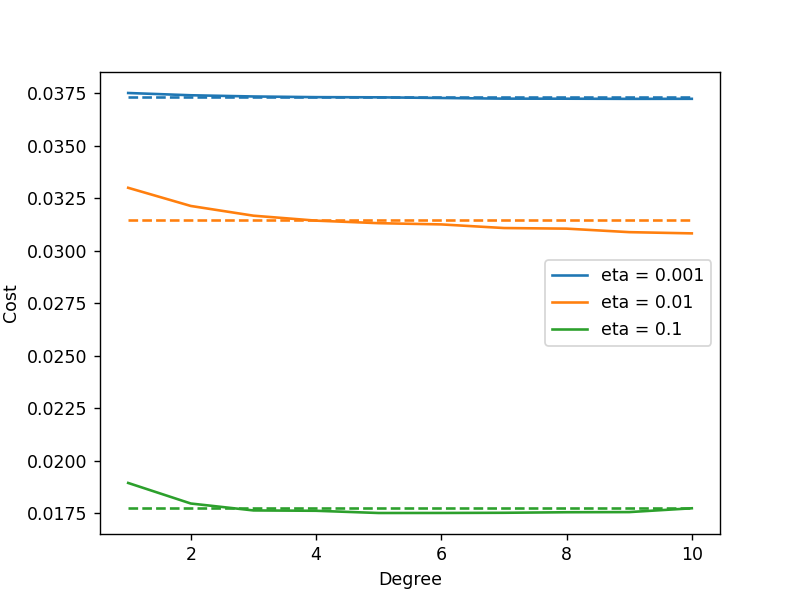

In [28]:
avg_cost = {}
plt.figure()
for eta in etas:
    color = next(plt.gca()._get_lines.prop_cycler)['color']
    plt.plot(list(temp_val_cost_sgd[eta].keys()), list(temp_val_cost_sgd[eta].values()), color = color, label = f'eta = {eta}')
    avg_cost[eta] = np.mean(list(temp_val_cost_sgd[eta].values()))
    plt.plot(np.arange(1, max_degree + 1), [avg_cost[eta]] * max_degree, '--', color = color)
plt.xlabel('Degree')
plt.ylabel('Cost')
plt.legend();

### Finding best learning rate

In [29]:
best_eta_sgd = min(avg_cost, key = avg_cost.get)
print(f'Best learning rate with lowest average validation cost is {best_eta_sgd}')

W_sgd['nr'] = temp_W_sgd[best_eta_sgd]
train_cost_sgd['nr'] = temp_train_cost_sgd[best_eta_sgd]
train_accuracy_sgd['nr'] = temp_train_accuracy_sgd[best_eta_sgd]
val_cost_sgd['nr'] = temp_val_cost_sgd[best_eta_sgd]
val_accuracy_sgd['nr'] = temp_val_accuracy_sgd[best_eta_sgd]

Best learning rate with lowest average validation cost is 0.1


In [39]:
val_cost_sgd['nr']

{1: 0.01893110463974378,
 2: 0.017951431844620835,
 3: 0.01762147958184847,
 4: 0.017605008322511734,
 5: 0.0174993762047556,
 6: 0.01750146261183999,
 7: 0.017509910390020235,
 8: 0.01753563366102334,
 9: 0.01754269150695262,
 10: 0.017724045408311795}

### Running with Lasso Regularization for various $ \lambda $

In [30]:
temp_W_sgd = {}
temp_train_cost_sgd = {}
temp_train_accuracy_sgd = {}
temp_val_cost_sgd = {}
temp_val_accuracy_sgd = {}

max_degree = 10
num_lambdas = 10
X_train, Y_train, X_val, Y_val, _, _ = shuffle(normal_df, train_ratio = 0.7, val_ratio = 0.2, target = 'charges')

for i in range(1, max_degree + 1):
    temp_W_sgd[i] = {}
    temp_train_cost_sgd[i] = {}
    temp_train_accuracy_sgd[i] = {}
    temp_val_cost_sgd[i] = {}
    temp_val_accuracy_sgd[i] = {}
    
    poly = PolynomialFeatures(i)
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.fit_transform(X_val)
    
    lambdas = np.random.uniform(0, 1, size = num_lambdas).tolist()
    for lambda1 in lambdas:
        print(f'Training {i}-degree model with lambda = {lambda1}')
        
        W = initialize_weights(X_train_poly)
        temp_W_sgd[i][lambda1], temp_train_cost_sgd[i][lambda1], temp_train_accuracy_sgd[i][lambda1] = \
                                    stochastic_gradient_descent(X_train_poly, Y_train, W, eta = best_eta_gd, lambda1 = lambda1)
        
        predictions = predict(temp_W_sgd[i][lambda1], X_val_poly)
        temp_val_cost_sgd[i][lambda1] = calculate_cost(Y_val, predictions, temp_W_sgd[i][lambda1], lambda1 = lambda1)
        temp_val_accuracy_sgd[i][lambda1] = calculate_accuracy(Y_val, predictions)
        print()
        print(f'Validation Cost = {temp_val_cost_sgd[i][lambda1]}, Validation Accuracy = {temp_val_accuracy_sgd[i][lambda1]}')
        print()

Training 1-degree model with lambda = 0.10682458853532029
Cost after 1 iterations is 0.037900944800076, accuracy = -0.9671722278178632
Cost after 2000 iterations is 0.03711006166988716, accuracy = -0.9261079339623168
Cost after 4000 iterations is 0.03640609244302548, accuracy = -0.8895562685060616
Cost after 6000 iterations is 0.035749318840930466, accuracy = -0.8554548738601133
Cost after 8000 iterations is 0.03510407710535719, accuracy = -0.8219519984816588
Cost after 10000 iterations is 0.034516108334038904, accuracy = -0.7914227607086575

Validation Cost = 0.030166620046498626, Validation Accuracy = -0.9006781117178386

Training 1-degree model with lambda = 0.585150611885149
Cost after 1 iterations is 0.037900919354641176, accuracy = -0.9671708378804693
Cost after 2000 iterations is 0.03790165616948882, accuracy = -0.9672090921879142
Cost after 4000 iterations is 0.03790148176039884, accuracy = -0.9672000821180273
Cost after 6000 iterations is 0.037900603480439624, accuracy = -0.96

Cost after 2000 iterations is 0.037900866056498304, accuracy = -0.9671678479844337
Cost after 4000 iterations is 0.037900551252200314, accuracy = -0.9671513560108478
Cost after 6000 iterations is 0.03790223340308679, accuracy = -0.9672388897569693
Cost after 8000 iterations is 0.03789954596370383, accuracy = -0.9670991439525556
Cost after 10000 iterations is 0.03789948215852147, accuracy = -0.9670958592461689

Validation Cost = 0.03344830871010457, Validation Accuracy = -1.107754531660686

Training 2-degree model with lambda = 0.8697506549434073
Cost after 1 iterations is 0.037901406829169454, accuracy = -0.9671961588157127
Cost after 2000 iterations is 0.03790181857807558, accuracy = -0.9672171881358416
Cost after 4000 iterations is 0.03790144541174787, accuracy = -0.9671978953078886
Cost after 6000 iterations is 0.03790145794707378, accuracy = -0.9671985712913664
Cost after 8000 iterations is 0.03790131914354325, accuracy = -0.96719149280918
Cost after 10000 iterations is 0.037900135

Cost after 2000 iterations is 0.03790071729062437, accuracy = -0.9671596617947815
Cost after 4000 iterations is 0.037900448442800896, accuracy = -0.9671458643518827
Cost after 6000 iterations is 0.03790059105874729, accuracy = -0.9671531359821923
Cost after 8000 iterations is 0.037901629033130345, accuracy = -0.967206818897069
Cost after 10000 iterations is 0.0379003762329634, accuracy = -0.9671419558055341

Validation Cost = 0.033449270560075975, Validation Accuracy = -1.1078138331204848

Training 3-degree model with lambda = 0.8830007044802829
Cost after 1 iterations is 0.03790083020777159, accuracy = -0.967166057121468
Cost after 2000 iterations is 0.03789813985742911, accuracy = -0.9670256007749491
Cost after 4000 iterations is 0.037900684802169994, accuracy = -0.9671579938489105
Cost after 6000 iterations is 0.03790024447305606, accuracy = -0.9671352162015838
Cost after 8000 iterations is 0.03790232662408973, accuracy = -0.9672433824194908
Cost after 10000 iterations is 0.03790161

Cost after 2000 iterations is 0.037900965490051376, accuracy = -0.9671727139582948
Cost after 4000 iterations is 0.03790127042166209, accuracy = -0.967188579606965
Cost after 6000 iterations is 0.037901154811772926, accuracy = -0.967182712017223
Cost after 8000 iterations is 0.03789936820033958, accuracy = -0.9670897062046999
Cost after 10000 iterations is 0.03790026932454537, accuracy = -0.9671365872812212

Validation Cost = 0.033449083378736415, Validation Accuracy = -1.1078028033428322

Training 5-degree model with lambda = 0.632555437929992
Cost after 1 iterations is 0.03790136152819188, accuracy = -0.9671938169966643
Cost after 2000 iterations is 0.03790037676388292, accuracy = -0.9671421695872788
Cost after 4000 iterations is 0.037900688109290856, accuracy = -0.9671583082077437
Cost after 6000 iterations is 0.03789895082563927, accuracy = -0.9670678758488691
Cost after 8000 iterations is 0.03790034197803497, accuracy = -0.9671402358372414
Cost after 10000 iterations is 0.03790066

Cost after 4000 iterations is 0.03790089124991686, accuracy = -0.9671684339426048
Cost after 6000 iterations is 0.03790274520505172, accuracy = -0.9672646428542973
Cost after 8000 iterations is 0.037899056801773336, accuracy = -0.9670729614120497
Cost after 10000 iterations is 0.03790153761836138, accuracy = -0.9672020385967484

Validation Cost = 0.033450354953807514, Validation Accuracy = -1.1078813321139758

Training 6-degree model with lambda = 0.28181171271660155
Cost after 1 iterations is 0.03790083162441073, accuracy = -0.9671663105933312
Cost after 2000 iterations is 0.03769499398922624, accuracy = -0.9564742179225802
Cost after 4000 iterations is 0.03747411600113833, accuracy = -0.9450009599758966
Cost after 6000 iterations is 0.03726353311395439, accuracy = -0.9340624701631655
Cost after 8000 iterations is 0.03706916763591544, accuracy = -0.9239661357695459
Cost after 10000 iterations is 0.0369025430756625, accuracy = -0.915311055879336

Validation Cost = 0.032482361888087195,

Cost after 4000 iterations is 0.03789973794401651, accuracy = -0.9671077920957438
Cost after 6000 iterations is 0.03790074131802636, accuracy = -0.9671600725487672
Cost after 8000 iterations is 0.037899877052910445, accuracy = -0.9671150262736405
Cost after 10000 iterations is 0.03790140159498244, accuracy = -0.9671943074035299

Validation Cost = 0.03345026360938253, Validation Accuracy = -1.107872727006749

Training 7-degree model with lambda = 0.40410713178053015
Cost after 1 iterations is 0.037900088627361606, accuracy = -0.9671274649788766
Cost after 2000 iterations is 0.03789532060953471, accuracy = -0.9668794466198682
Cost after 4000 iterations is 0.0378956137069453, accuracy = -0.9668946543046713
Cost after 6000 iterations is 0.037898302267215495, accuracy = -0.967034482094629
Cost after 8000 iterations is 0.03789896721269401, accuracy = -0.9670690572347442
Cost after 10000 iterations is 0.03790071673838582, accuracy = -0.9671599534387507

Validation Cost = 0.03344951576319206, 

Cost after 4000 iterations is 0.03789985763342882, accuracy = -0.9671147772893736
Cost after 6000 iterations is 0.03789998879794724, accuracy = -0.9671216630816286
Cost after 8000 iterations is 0.03790135445936431, accuracy = -0.9671925685689475
Cost after 10000 iterations is 0.03790123804729283, accuracy = -0.967186641481895

Validation Cost = 0.033450054010398064, Validation Accuracy = -1.1078630112304735

Training 8-degree model with lambda = 0.7523356579056254
Cost after 1 iterations is 0.03790125644907172, accuracy = -0.9671882774749525
Cost after 2000 iterations is 0.037900230107963805, accuracy = -0.9671331585792087
Cost after 4000 iterations is 0.03790279846343661, accuracy = -0.967266649229445
Cost after 6000 iterations is 0.03790229713485681, accuracy = -0.9672406495732915
Cost after 8000 iterations is 0.03789818179067185, accuracy = -0.9670265119773476
Cost after 10000 iterations is 0.037900449151956235, accuracy = -0.9671447755670666

Validation Cost = 0.033449405064173064,

Cost after 4000 iterations is 0.03790272704560017, accuracy = -0.9672599521974563
Cost after 6000 iterations is 0.03790190940904276, accuracy = -0.967217569552449
Cost after 8000 iterations is 0.03790221653915641, accuracy = -0.96723346035602
Cost after 10000 iterations is 0.03790175089004933, accuracy = -0.9672091650711943

Validation Cost = 0.0334507348367397, Validation Accuracy = -1.1078885334181998

Training 10-degree model with lambda = 0.4151808749938708
Cost after 1 iterations is 0.03790057051598331, accuracy = -0.9671527001685685
Cost after 2000 iterations is 0.03789836229728354, accuracy = -0.9670371425846447
Cost after 4000 iterations is 0.03790103629323426, accuracy = -0.9671761446118992
Cost after 6000 iterations is 0.03790136839331558, accuracy = -0.96719342643767
Cost after 8000 iterations is 0.0379005116751953, accuracy = -0.9671487614458332
Cost after 10000 iterations is 0.03789858645452825, accuracy = -0.9670488197159752

Validation Cost = 0.033447553555774015, Valida

### Finding best $ \lambda $ for different degrees

In [31]:
best_lambda1_sgd = {i: min(temp_val_cost_sgd[i], key = temp_val_cost_sgd[i].get) for i in range(1, max_degree + 1)}
best_lambda1_sgd

{1: 0.10682458853532029,
 2: 0.07782028167508359,
 3: 0.07887295507267034,
 4: 0.08393367646951211,
 5: 0.22625914727342455,
 6: 0.10278966646332144,
 7: 0.21335627949938085,
 8: 0.18784342973618084,
 9: 0.029359931927802285,
 10: 0.08781728020822865}

In [32]:
W_sgd['r1'] = {i: {'W':temp_W_sgd[i][best_lambda1_sgd[i]], 'lambda': best_lambda1_sgd[i]} for i in range(1, max_degree + 1)}
train_cost_sgd['r1'] = {i: {'cost':temp_train_cost_sgd[i][best_lambda1_sgd[i]], 'lambda': best_lambda1_sgd[i]} for i in range(1, max_degree + 1)}
train_accuracy_sgd['r1'] = {i: {'cost':temp_train_accuracy_sgd[i][best_lambda1_sgd[i]], 'lambda': best_lambda1_sgd[i]} for i in range(1, max_degree + 1)}
val_cost_sgd['r1'] = {i: {'cost':temp_val_cost_sgd[i][best_lambda1_sgd[i]], 'lambda': best_lambda1_sgd[i]} for i in range(1, max_degree + 1)}
val_accuracy_sgd['r1'] = {i: {'cost':temp_val_accuracy_sgd[i][best_lambda1_sgd[i]], 'lambda': best_lambda1_sgd[i]} for i in range(1, max_degree + 1)}

In [40]:
val_cost_sgd['r1']

{1: {'cost': 0.030166620046498626, 'lambda': 0.10682458853532029},
 2: {'cost': 0.02950908202652078, 'lambda': 0.07782028167508359},
 3: {'cost': 0.029391606754609556, 'lambda': 0.07887295507267034},
 4: {'cost': 0.029418511432425205, 'lambda': 0.08393367646951211},
 5: {'cost': 0.03190596119676785, 'lambda': 0.22625914727342455},
 6: {'cost': 0.029973944583621757, 'lambda': 0.10278966646332144},
 7: {'cost': 0.03187950821866778, 'lambda': 0.21335627949938085},
 8: {'cost': 0.031500161599078653, 'lambda': 0.18784342973618084},
 9: {'cost': 0.02779243901647746, 'lambda': 0.029359931927802285},
 10: {'cost': 0.02949585201302009, 'lambda': 0.08781728020822865}}

### Running with Ridge Regularization for various $ \lambda $

In [33]:
temp_W_sgd = {}
temp_train_cost_sgd = {}
temp_train_accuracy_sgd = {}
temp_val_cost_sgd = {}
temp_val_accuracy_sgd = {}

max_degree = 10
num_lambdas = 10
X_train, Y_train, X_val, Y_val, _, _ = shuffle(normal_df, train_ratio = 0.7, val_ratio = 0.2, target = 'charges')

for i in range(1, max_degree + 1):
    temp_W_sgd[i] = {}
    temp_train_cost_sgd[i] = {}
    temp_train_accuracy_sgd[i] = {}
    temp_val_cost_sgd[i] = {}
    temp_val_accuracy_sgd[i] = {}
    
    poly = PolynomialFeatures(i)
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.fit_transform(X_val)
    
    lambdas = np.random.uniform(0, 1, size = num_lambdas).tolist()
    for lambda2 in lambdas:
        print(f'Training {i}-degree model with lambda = {lambda2}')
        
        W = initialize_weights(X_train_poly)
        temp_W_sgd[i][lambda2], temp_train_cost_sgd[i][lambda2], temp_train_accuracy_sgd[i][lambda2] = \
                                    stochastic_gradient_descent(X_train_poly, Y_train, W, eta = best_eta_gd, lambda2 = lambda2)
        
        predictions = predict(temp_W_sgd[i][lambda2], X_val_poly)
        temp_val_cost_sgd[i][lambda2] = calculate_cost(Y_val, predictions, temp_W_sgd[i][lambda2], lambda2 = lambda2)
        temp_val_accuracy_sgd[i][lambda2] = calculate_accuracy(Y_val, predictions)
        print()
        print(f'Validation Cost = {temp_val_cost_sgd[i][lambda2]}, Validation Accuracy = {temp_val_accuracy_sgd[i][lambda2]}')
        print()

Training 1-degree model with lambda = 0.5403904158311524
Cost after 1 iterations is 0.03912898919933334, accuracy = -0.9970393055534852
Cost after 2000 iterations is 0.037893554470003844, accuracy = -0.9339856156086082
Cost after 4000 iterations is 0.03672725808780677, accuracy = -0.8744598158055636
Cost after 6000 iterations is 0.035656150715479486, accuracy = -0.8197915828715547
Cost after 8000 iterations is 0.03469956765875435, accuracy = -0.7709679189414738
Cost after 10000 iterations is 0.033781805364259045, accuracy = -0.7241250387909364

Validation Cost = 0.02659005370619135, Validation Accuracy = -0.7653789338085617

Training 1-degree model with lambda = 0.13712750420583852
Cost after 1 iterations is 0.03912861037458065, accuracy = -0.9970199713479033
Cost after 2000 iterations is 0.03793821980505898, accuracy = -0.9362655168996721
Cost after 4000 iterations is 0.03675439993028314, accuracy = -0.8758462182981803
Cost after 6000 iterations is 0.03566971690857369, accuracy = -0.8

Cost after 2000 iterations is 0.037727795887048346, accuracy = -0.9255259544479142
Cost after 4000 iterations is 0.036412564323858365, accuracy = -0.858399523896922
Cost after 6000 iterations is 0.035207962791121226, accuracy = -0.7969190709927467
Cost after 8000 iterations is 0.034012331880996664, accuracy = -0.7358961181166754
Cost after 10000 iterations is 0.03295876274512986, accuracy = -0.682123441950498

Validation Cost = 0.025932507106215884, Validation Accuracy = -0.7217414503140243

Training 2-degree model with lambda = 0.06254151052516665
Cost after 1 iterations is 0.03912857631320885, accuracy = -0.9970182329462862
Cost after 2000 iterations is 0.037701147239019406, accuracy = -0.9241660059760755
Cost after 4000 iterations is 0.0363780320950933, accuracy = -0.8566375884806796
Cost after 6000 iterations is 0.03509503694871024, accuracy = -0.7911566920901012
Cost after 8000 iterations is 0.0339741031161464, accuracy = -0.7339469137890704
Cost after 10000 iterations is 0.032895

Cost after 2000 iterations is 0.03756514872371181, accuracy = -0.9172241598125712
Cost after 4000 iterations is 0.03618331724234374, accuracy = -0.8466967695864469
Cost after 6000 iterations is 0.0349068804296257, accuracy = -0.7815471374851604
Cost after 8000 iterations is 0.03376915053709265, accuracy = -0.7234758035492974
Cost after 10000 iterations is 0.032763580750804516, accuracy = -0.6721489495212594

Validation Cost = 0.025801938198558742, Validation Accuracy = -0.7130136952447617

Training 3-degree model with lambda = 0.5828828996637752
Cost after 1 iterations is 0.03912770406760313, accuracy = -0.9969737158552558
Cost after 2000 iterations is 0.03762121634290674, accuracy = -0.9200861008111825
Cost after 4000 iterations is 0.03621335855361211, accuracy = -0.8482313645737591
Cost after 6000 iterations is 0.03482418258662857, accuracy = -0.7773291002836946
Cost after 8000 iterations is 0.03366633339239748, accuracy = -0.7182326821247578
Cost after 10000 iterations is 0.03257330

Cost after 2000 iterations is 0.03749579310027181, accuracy = -0.9136851309066245
Cost after 4000 iterations is 0.0360443356456061, accuracy = -0.8396060739791951
Cost after 6000 iterations is 0.03469046036764892, accuracy = -0.7705070449444782
Cost after 8000 iterations is 0.03344014026961696, accuracy = -0.7066929326223941
Cost after 10000 iterations is 0.032250526316244386, accuracy = -0.6459768266442976

Validation Cost = 0.025390256953276322, Validation Accuracy = -0.6857388387553411

Training 5-degree model with lambda = 0.0930633522601817
Cost after 1 iterations is 0.03912852907064679, accuracy = -0.9970158218118468
Cost after 2000 iterations is 0.037391341731736465, accuracy = -0.9083543134970673
Cost after 4000 iterations is 0.035869321178299066, accuracy = -0.8306741835130291
Cost after 6000 iterations is 0.03441818152215332, accuracy = -0.7566114678480431
Cost after 8000 iterations is 0.033118749735484426, accuracy = -0.6902914024974285
Cost after 10000 iterations is 0.03191

Cost after 2000 iterations is 0.03733497016606882, accuracy = -0.9054769570129482
Cost after 4000 iterations is 0.03575345647076742, accuracy = -0.824759642531375
Cost after 6000 iterations is 0.0343545794215267, accuracy = -0.7533631038407671
Cost after 8000 iterations is 0.03304160306197801, accuracy = -0.6863501922790267
Cost after 10000 iterations is 0.03183909176431363, accuracy = -0.6249747126042116

Validation Cost = 0.025072065915549654, Validation Accuracy = -0.6645965714288209

Training 6-degree model with lambda = 0.9603172769819163
Cost after 1 iterations is 0.03912807939880315, accuracy = -0.9969928717592542
Cost after 2000 iterations is 0.03745145351189107, accuracy = -0.9114214451830316
Cost after 4000 iterations is 0.03592038808535052, accuracy = -0.8332773959862376
Cost after 6000 iterations is 0.03452321116638046, accuracy = -0.7619652711856555
Cost after 8000 iterations is 0.03327232361540678, accuracy = -0.6981183132641178
Cost after 10000 iterations is 0.0321365095

Cost after 2000 iterations is 0.037395312924132604, accuracy = -0.9085565373892759
Cost after 4000 iterations is 0.03578816371642657, accuracy = -0.8265303425209032
Cost after 6000 iterations is 0.034403761498991436, accuracy = -0.7558718461361291
Cost after 8000 iterations is 0.03309891423539914, accuracy = -0.6892728622934801
Cost after 10000 iterations is 0.0318995944692956, accuracy = -0.6280591086145624

Validation Cost = 0.025127023625214615, Validation Accuracy = -0.6682295038837118

Training 7-degree model with lambda = 0.35313953647340846
Cost after 1 iterations is 0.03912743572230322, accuracy = -0.9969600202264775
Cost after 2000 iterations is 0.037395857487777975, accuracy = -0.9085845315759129
Cost after 4000 iterations is 0.035810149794936685, accuracy = -0.8276532488015302
Cost after 6000 iterations is 0.034370916441964, accuracy = -0.7541970929576167
Cost after 8000 iterations is 0.0330676465751753, accuracy = -0.6876797157702284
Cost after 10000 iterations is 0.0318124

Cost after 2000 iterations is 0.03738824462163187, accuracy = -0.9081962252487281
Cost after 4000 iterations is 0.03576886471274888, accuracy = -0.8255470536941854
Cost after 6000 iterations is 0.03433597330035048, accuracy = -0.7524155886899926
Cost after 8000 iterations is 0.03297183178895985, accuracy = -0.682792754075559
Cost after 10000 iterations is 0.03165669851653083, accuracy = -0.6156709786040162

Validation Cost = 0.02492975211906019, Validation Accuracy = -0.6551711460354042

Training 8-degree model with lambda = 0.5873189039116322
Cost after 1 iterations is 0.0391279447460464, accuracy = -0.9969859994415993
Cost after 2000 iterations is 0.03743023888779837, accuracy = -0.9103390653032755
Cost after 4000 iterations is 0.03580551970450601, accuracy = -0.827416078947522
Cost after 6000 iterations is 0.03432889011837854, accuracy = -0.7520502635062716
Cost after 8000 iterations is 0.03304671491427628, accuracy = -0.6866082791667332
Cost after 10000 iterations is 0.031915152565

Cost after 2000 iterations is 0.03728237626720862, accuracy = -0.9027930167154206
Cost after 4000 iterations is 0.03565136386679727, accuracy = -0.8195502564198129
Cost after 6000 iterations is 0.03406202428888493, accuracy = -0.7384342086892441
Cost after 8000 iterations is 0.03272602464464793, accuracy = -0.6702478768927012
Cost after 10000 iterations is 0.031429075284011614, accuracy = -0.6040544393799083

Validation Cost = 0.02475607188256519, Validation Accuracy = -0.6436432265222771

Training 10-degree model with lambda = 0.02903573526593517
Cost after 1 iterations is 0.03912856097902146, accuracy = -0.9970174503302396
Cost after 2000 iterations is 0.03725495504100741, accuracy = -0.9013935649264937
Cost after 4000 iterations is 0.035621013919726864, accuracy = -0.8180014789466479
Cost after 6000 iterations is 0.034162086659485454, accuracy = -0.7435415910124232
Cost after 8000 iterations is 0.0327412147161544, accuracy = -0.671023894594647
Cost after 10000 iterations is 0.031392

### Finding best $ \lambda $ for different degrees

In [34]:
best_lambda2_sgd = {i: min(temp_val_cost_sgd[i], key = temp_val_cost_sgd[i].get) for i in range(1, max_degree + 1)}
best_lambda2_sgd

{1: 0.37099480088104386,
 2: 0.06254151052516665,
 3: 0.040684571821222204,
 4: 0.10042959638014104,
 5: 0.07313421139279908,
 6: 0.16379579797670607,
 7: 0.18781097853282414,
 8: 0.18471576413799828,
 9: 0.08050129018832941,
 10: 0.02903573526593517}

In [35]:
W_sgd['r2'] = {i: {'W':temp_W_sgd[i][best_lambda2_sgd[i]], 'lambda': best_lambda2_sgd[i]} for i in range(1, max_degree + 1)}
train_cost_sgd['r2'] = {i: {'cost':temp_train_cost_sgd[i][best_lambda2_sgd[i]], 'lambda': best_lambda2_sgd[i]} for i in range(1, max_degree + 1)}
train_accuracy_sgd['r2'] = {i: {'cost':temp_train_accuracy_sgd[i][best_lambda2_sgd[i]], 'lambda': best_lambda2_sgd[i]} for i in range(1, max_degree + 1)}
val_cost_sgd['r2'] = {i: {'cost':temp_val_cost_sgd[i][best_lambda2_sgd[i]], 'lambda': best_lambda2_sgd[i]} for i in range(1, max_degree + 1)}
val_accuracy_sgd['r2'] = {i: {'cost':temp_val_accuracy_sgd[i][best_lambda2_sgd[i]], 'lambda': best_lambda2_sgd[i]} for i in range(1, max_degree + 1)}

In [41]:
val_cost_sgd['r2']

{1: {'cost': 0.026526232286522795, 'lambda': 0.37099480088104386},
 2: {'cost': 0.02587849717170104, 'lambda': 0.06254151052516665},
 3: {'cost': 0.025499099197853755, 'lambda': 0.040684571821222204},
 4: {'cost': 0.025271775748190502, 'lambda': 0.10042959638014104},
 5: {'cost': 0.025027445029776368, 'lambda': 0.07313421139279908},
 6: {'cost': 0.02499876585402694, 'lambda': 0.16379579797670607},
 7: {'cost': 0.024949487033953752, 'lambda': 0.18781097853282414},
 8: {'cost': 0.024928343087573558, 'lambda': 0.18471576413799828},
 9: {'cost': 0.024800045562832353, 'lambda': 0.08050129018832941},
 10: {'cost': 0.02472240108923681, 'lambda': 0.02903573526593517}}